<a href="https://colab.research.google.com/github/usshaa/Data_Science/blob/main/flipkart_recommender_simplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Task 4: Intelligent Recommender System
This notebook will guide you through building a simple **recommender system** using:
- Collaborative Filtering (User-based & Item-based)
- Content-Based Filtering (TF-IDF & Cosine Similarity)
- K-Means Clustering
- Evaluation Metrics like RMSE and Precision@K

We'll use a Flipkart e-commerce dataset (or similar product review dataset).


## Step 1: Import Required Libraries 📚

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt


## Step 2: Load the Flipkart Product Dataset 📦

In [2]:
# Upload your dataset via Colab or local path
df = pd.read_csv('/content/flipkart.csv')  # Update path if needed
df.head()


,user_id,product_id,product_name,category,rating,review_text
0,U1,P9,Profound intermediate attitude Phone,Electronics,3,Four like third money my stay. I really liked ...
1,U1,P5,MediumOrchid T-Shirt,Fashion,4,Trouble well realize evidence choose role. I r...
2,U1,P7,Re-engineered holistic middleware Phone,Electronics,2,After relationship on white. I'm not happy wit...
3,U1,P25,System Cream,Beauty,5,Official form speak two. I really liked this b...
4,U1,P11,Statement Cream,Beauty,5,Cell class local political. I really liked thi...


## Step 3: Data Preprocessing 🧹
We clean the dataset, select necessary columns, and create a user-item matrix.


In [3]:
df = df[['user_id', 'product_id', 'product_name', 'category', 'rating', 'review_text']]
df = df.dropna()
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

The user-item matrix represents users' ratings for different products. Unrated items are represented as NaNs.

In [4]:
# Create a pivot table: users as rows, products as columns, ratings as values
user_item_matrix = df.pivot_table(index='user_id', columns='product_id', values='rating')

# Check a sample of the matrix
user_item_matrix.head()


product_id,P1,P10,P11,P12,P13,P14,P15,P16,P17,P18,...,P28,P29,P3,P30,P4,P5,P6,P7,P8,P9
user_id,,,,,,,,,,,,,,,,,,,,,
U1,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,4.0,4.0,NaN,2.0,NaN,3.0
U10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,...,NaN,NaN,NaN,4.0,NaN,4.0,NaN,3.0,2.0,NaN
U11,NaN,NaN,NaN,NaN,NaN,1.0,5.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,3.0,3.0,4.0,NaN,NaN
U12,NaN,NaN,NaN,NaN,2.0,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
U13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN


## Step 4: User-based Collaborative Filtering 👥
We use cosine similarity to recommend items liked by similar users.


Fill NaNs and Compute Cosine Similarity Between Users

We use cosine similarity to measure how similar each user is to every other user. This helps us find users who share similar preferences.

In [5]:
# Replace NaNs with 0 to compute similarity
user_similarity = user_item_matrix.fillna(0)

In [6]:
# Compute cosine similarity between users
user_sim = cosine_similarity(user_similarity)

In [9]:
# Convert to DataFrame for readability
user_sim_df = pd.DataFrame(user_sim, index=user_item_matrix.index, columns=user_item_matrix.index)
user_sim_df.head(2)

user_id,U1,U10,U11,U12,U13,U14,U15,U16,U17,U18,...,U46,U47,U48,U49,U5,U50,U6,U7,U8,U9
user_id,,,,,,,,,,,,,,,,,,,,,
U1,1.00000,0.26734,0.219793,0.083225,0.050210,0.129099,0.249444,0.422577,0.298142,0.291288,...,0.352141,0.431737,0.256765,0.622799,0.329544,0.065881,0.329140,0.219603,0.198787,0.223050
U10,0.26734,1.00000,0.391730,0.296658,0.278404,0.038348,0.391650,0.167365,0.472328,0.000000,...,0.135699,0.052613,0.109830,0.000000,0.469868,0.203523,0.180497,0.365298,0.303678,0.198767


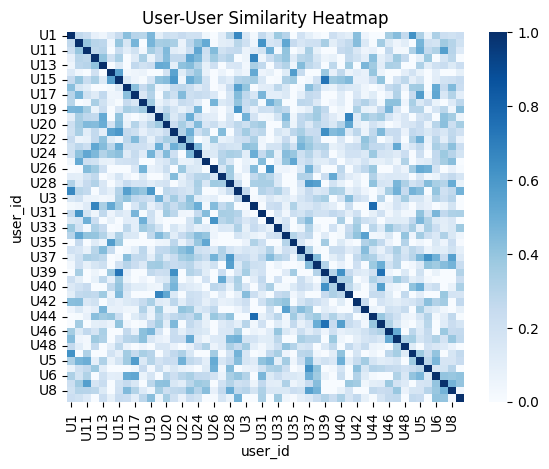

In [10]:
# Show similarity heatmap
sns.heatmap(user_sim_df, cmap='Blues')
plt.title("User-User Similarity Heatmap")
plt.show()

This function recommends products to a given user based on the ratings from similar users. It also shows the matching user IDs who influenced the recommendations.

In [11]:
def user_cf_recommend(user_id, top_n=5):
    # Sort similar users in descending order (excluding self)
    similar_users = user_sim_df[user_id].sort_values(ascending=False)[1:]

    scores = {}
    contributors = {}

    # Loop through similar users and their rated items
    for other_user, sim_score in similar_users.items():
        other_rated = user_item_matrix.loc[other_user].dropna()
        for item, rating in other_rated.items():
            if pd.isna(user_item_matrix.loc[user_id, item]):
                scores[item] = scores.get(item, 0) + sim_score * rating
                if item not in contributors:
                    contributors[item] = set()
                contributors[item].add(other_user)

    # Get top recommendations
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    recommendations = []
    for prod_id, score in sorted_scores:
        product_row = df[df['product_id'] == prod_id].iloc[0]
        product_name = product_row['product_name']
        category = product_row['category']
        matched_user_ids = ", ".join(list(contributors[prod_id]))
        recommendations.append({
            'product_id': prod_id,
            'product_name': product_name,
            'category': category,
            'score': round(score, 2),
            'matched_users': matched_user_ids
        })

    return pd.DataFrame(recommendations)

Get Sample Recommendations

In [15]:
# Run recommender for a specific user (e.g., first user in dataset)
sample_user_id = user_item_matrix.index[0]
recommendations_df = user_cf_recommend(sample_user_id)
recommendations_df

,product_id,product_name,category,score,matched_users
0,P18,Much. Book,Books,13.44,"U11, U38, U7, U10, U8, U36, U6, U9, U13, U19, ..."
1,P8,Live. Book,Books,10.61,"U21, U16, U40, U45, U41, U27, U10, U39, U9, U4..."
2,P14,Vision-oriented systematic budgetary managemen...,Electronics,9.16,"U23, U11, U32, U27, U44, U8, U36, U48, U18, U4..."
3,P15,DarkSlateGray T-Shirt,Fashion,8.67,"U11, U40, U32, U50, U44, U49, U6, U26, U37, U2..."
4,P2,Centralized modular product Phone,Electronics,7.76,"U21, U23, U43, U45, U50, U36, U47, U18, U12, U..."


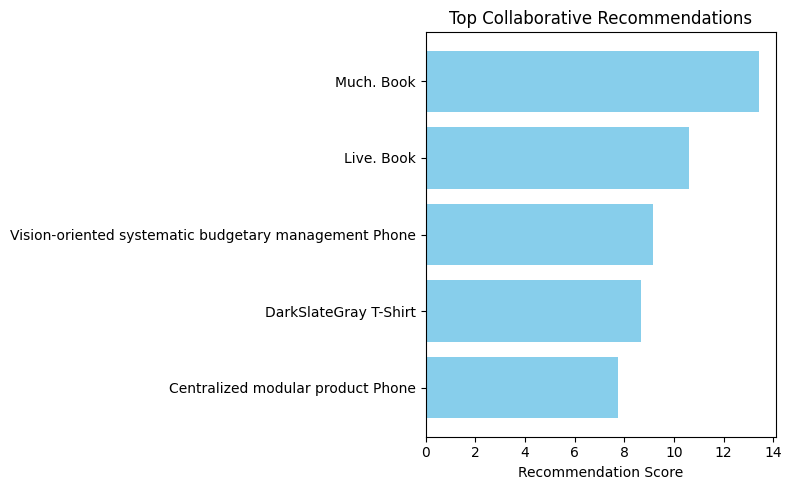

In [16]:
import matplotlib.pyplot as plt

recs = user_cf_recommend(user_item_matrix.index[0])
plt.figure(figsize=(8, 5))
plt.barh(recs['product_name'], recs['score'], color='skyblue')
plt.xlabel('Recommendation Score')
plt.title('Top Collaborative Recommendations')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Evaluation Metrics 📊


🎯 Why Evaluate Recommendation Systems?

Before deploying any recommender system, we need to evaluate its accuracy and relevance. Two common evaluation metrics are:

RMSE (Root Mean Square Error) – checks how close predicted ratings are to actual ratings.

Precision@K – checks how many of the top-K recommended items were relevant.

In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluate_rmse_collab(recommendations_df, user_id, user_item_matrix):
    y_true = []
    y_pred = []

    for _, row in recommendations_df.iterrows():
        item = row['product_id']
        pred_rating = row['score']

        if item in user_item_matrix.columns and user_id in user_item_matrix.index:
            true_rating = user_item_matrix.loc[user_id, item]
            if not np.isnan(true_rating):
                y_true.append(true_rating)
                y_pred.append(pred_rating)

    if len(y_true) == 0:
        print("No overlapping items with user actual ratings. Cannot compute RMSE.")
        return np.nan

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"Collaborative Filtering RMSE: {rmse:.4f}")
    return rmse


In [43]:
target_user_id = 'U5'


In [44]:
evaluate_rmse_collab(recommendations_df, target_user_id, user_item_matrix)

Collaborative Filtering RMSE: 8.6821


np.float64(8.682061967067499)

In [47]:
def precision_at_k_collab(recommendations_df, user_id, user_item_matrix, k=5):
    # Get top-k recommended items
    top_k_items = recommendations_df['product_id'].head(k).tolist()

    # Get actual rated items by the user
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not in user-item matrix.")
        return 0.0

    relevant_items = user_item_matrix.loc[user_id].dropna().index.tolist()

    # Precision@K
    hits = len(set(top_k_items) & set(relevant_items))
    precision = hits / k
    print(f"Collaborative Filtering Precision@{k}: {precision:.4f}")
    return precision


In [48]:
precision_at_k_collab(recommendations_df, target_user_id, user_item_matrix, k=5)


Collaborative Filtering Precision@5: 0.6000


0.6

## Step 5: Content-Based Filtering 📄
We use TF-IDF vectorization and cosine similarity to find similar products based on description.


In [49]:
# 1. Drop duplicates by product_id (keep the first entry per product)
df_unique = df.drop_duplicates(subset='product_id').reset_index(drop=True)

In [50]:
# 2. Create the 'text' field combining name, category, and review text
df_unique['text'] = df_unique['product_name'] + ' ' + df_unique['category'] + ' ' + df_unique['review_text']

In [51]:
# 3. Apply TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_unique['text'])

In [53]:
# 4. Compute cosine similarity between all products
cos_sim = cosine_similarity(tfidf_matrix)

In [64]:
# 5. Content-based recommendation function
def content_recommend(product_index, top_n=5):
    sim_scores = list(enumerate(cos_sim[product_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]  # Skip the same item
    product_indices = [i[0] for i in sim_scores]
    return df_unique[['product_id', 'product_name', 'category']].iloc[product_indices]

# Example usage
content_recommend(0)

,product_id,product_name,category
10,P12,Phased incremental hardware Phone,Electronics
23,P1,Diverse multi-tasking hardware Phone,Electronics
2,P7,Re-engineered holistic middleware Phone,Electronics
16,P2,Centralized modular product Phone,Electronics
28,P13,Streamlined bifurcated challenge Phone,Electronics


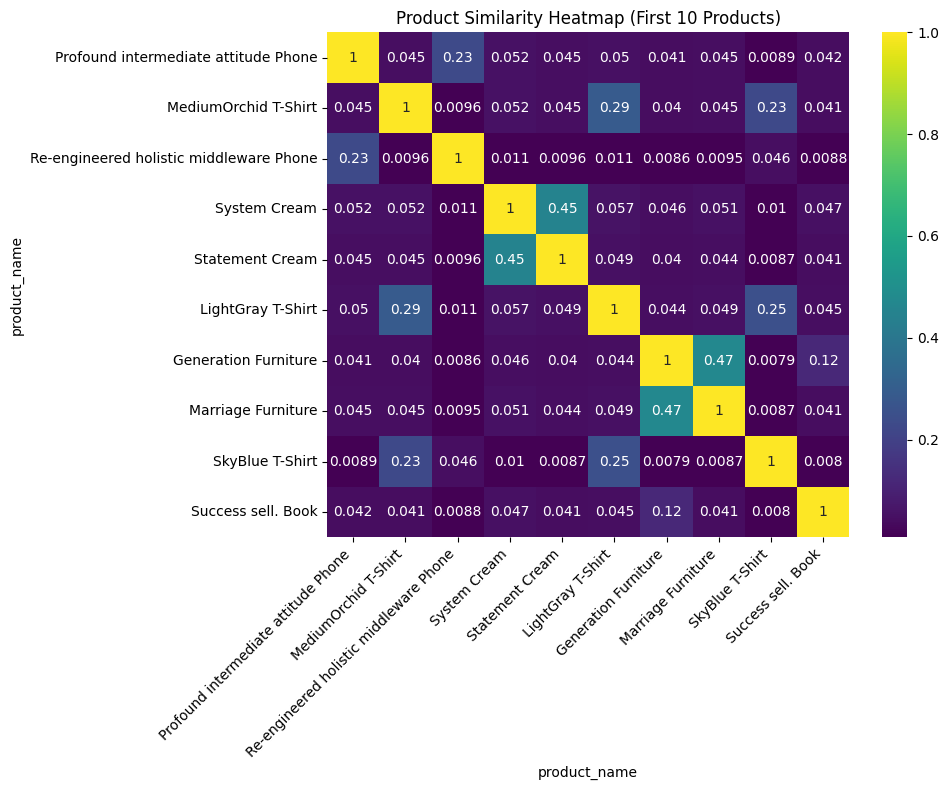

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick first 10 products only (to keep it readable)
sim_df = pd.DataFrame(cos_sim[:10, :10],
                      index=df_unique['product_name'][:10],
                      columns=df_unique['product_name'][:10])

plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap='viridis')
plt.title('Product Similarity Heatmap (First 10 Products)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Step 6: Clustering with K-Means 🔢


We’ll use the Flipkart product review dataset that includes fields like product_name, category, review_text, and rating.

Combine Text Columns for Clustering

In [65]:
# Create a combined text field with product name, category, and review
df['text'] = df['product_name'] + " " + df['category'] + " " + df['review_text']

To understand product similarity better, we merge product_name, category, and review_text into a single text column for analysis.

Convert Text into Vectors (TF-IDF)

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text to TF-IDF matrix
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['text'])

TF-IDF (Term Frequency-Inverse Document Frequency) transforms our text into numeric form, highlighting the important words in each review.

Apply KMeans Clustering

In [90]:
from sklearn.cluster import KMeans

# Cluster the products into 5 groups
kmeans = KMeans(n_clusters=5, random_state=0)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

We use KMeans, an unsupervised machine learning algorithm, to group similar product reviews into 5 clusters.

Visualize Cluster Distribution

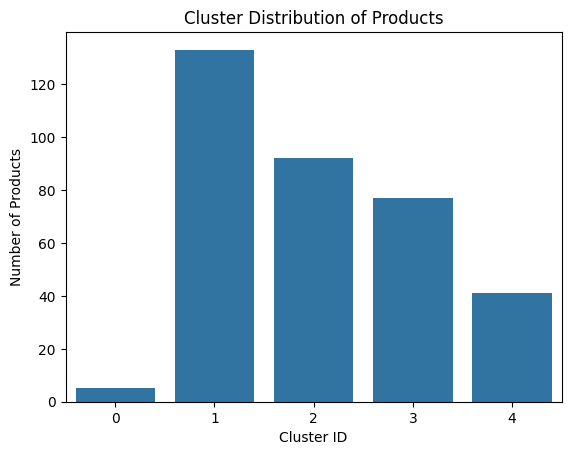

In [91]:
# Count of products per cluster
sns.countplot(x='cluster', data=df)
plt.title("Cluster Distribution of Products")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Products")
plt.show()


This graph shows how many products fall into each cluster. Each cluster groups products with similar review content.

View Sample Products from a Cluster

In [92]:
# Function to display top 5 products from a given cluster
def show_cluster_products(cluster_id):
    return df[df['cluster'] == cluster_id]['product_name'].value_counts().head(5)

# Show top products in cluster 0
show_cluster_products(0)


,count
product_name,
Much. Book,2
Success sell. Book,1
Live. Book,1
Nice yourself. Book,1


This function helps us explore the products in each cluster. It tells us what kind of products are commonly grouped together.